Calculating Energy Efficiency for an IRS-Assisted Wireless Network.
1. Using a 3D environment to model Base Station, IRS and Users.
2. Implementing on a 2 User system.
3. Starting with a Double-IRS Assisted Network, moving through different variations of concentric circles

In [93]:
# Importing all libraries

import numpy as np 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from Functions import *

In [94]:
#============== System parameters
'''
Defining Parameters
    Nt = Number of transmit antennas (SISO = 1)
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

'''
Nt = 1
K = 10
# gamma = db2pow(20)
f = 2.4e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
BW = 20e6
NF = 10
noise = -133 # -174+10*np.log10(BW) + NF

# Network Parameters
GRID_RADIUS = 1000
BASE_STATION_POSITION = (0, 0, 20)
USER_POS = generate_user_positions_3D(K, GRID_RADIUS)
TRANSMIT_POWER_WATTS = 0.1 #in watts
NUM_SIMULATIONS = 1000
dThreshold = GRID_RADIUS / 40

# Fading Paramters
FADING_STD_MEAN = 0
FADING_STD_DEV = 3
m = 1
omega = np.sqrt(0.5)

# Path Loss Parameters
ALPHA = 2.2 #path loss exponent (indirect - IRS 1)
BETA = 3.8 #path loss exponent  (indirect - IRS 1)
ZETA = 3.8 #path loss exponent  (direct)

# IRS Positions
nIRSrow = 10
nIRScol = nIRSrow
Ns = nIRScol * nIRSrow


# Power consumption params
wn = 0.5
Pb = 10 # in dBw
Pu = 10 # 10 in dBm

#Practical phase shift model paramters
a = 1.6
phi = 0.43 * np.pi
B_min = 0.2


loc_T = np.array([BASE_STATION_POSITION])
loc_U = USER_POS
print(USER_POS)
xt, yt, zt = BASE_STATION_POSITION

[[ -11.96811161  654.47230266    0.        ]
 [  81.61893856  -11.44119083    0.        ]
 [ 305.63766693  803.03403868    0.        ]
 [  35.31524947   75.4225277     0.        ]
 [  -3.07535586  587.01249756    0.        ]
 [-627.47039816  522.40782495    0.        ]
 [-126.90437952  577.81691009    0.        ]
 [  79.88902038   54.15871864    0.        ]
 [-848.00473287   65.12963806    0.        ]
 [-193.07222059  130.62704158    0.        ]]


In [95]:
IRS_X = np.arange(250,1250,250)
IRS_Y = np.arange(400,800,100)
IRS_Z = np.array([10,10,10,10])
IRS_POSITIONS_1 = np.column_stack((IRS_X, IRS_Y, IRS_Z))
IRS_POSITIONS_2 = np.column_stack((IRS_X, -IRS_Y, IRS_Z))
arr_gridradius = np.arange(250,1250,250) # dividing by 0.5 to cater to angle while remianing in concentric boundaries
arr_gridradius = np.array(arr_gridradius)


In [96]:

# IRS_POSITIONS_1 = np.zeros((4,1))
# IRS_POSITIONS_2 = np.zeros((4,1))
# print(np.cos(45))

# arr_gridradius = np.arange(250,1250,250) # dividing by 0.5 to cater to angle while remianing in concentric boundaries
# print(arr_gridradius)
# IRS_POSITIONS_1, IRS_POSITIONS_2= generate_positions_IRS(arr_gridradius)

# print(IRS_POSITIONS_1)
# print(IRS_POSITIONS_2)



Generating Positions for IRS, Users, BS

BS position:
 (0, 0, 20)
IRS-1 position:
 [250 400  10]
IRS-2 position:
 [ 250 -400   10]


BS position:
 (0, 0, 20)
IRS-1 position:
 [500 500  10]
IRS-2 position:
 [ 500 -500   10]
BS position:
 (0, 0, 20)
IRS-1 position:
 [750 600  10]
IRS-2 position:
 [ 750 -600   10]
BS position:
 (0, 0, 20)
IRS-1 position:
 [1000  700   10]
IRS-2 position:
 [1000 -700   10]


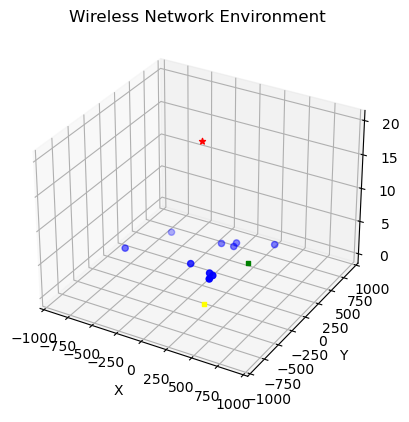

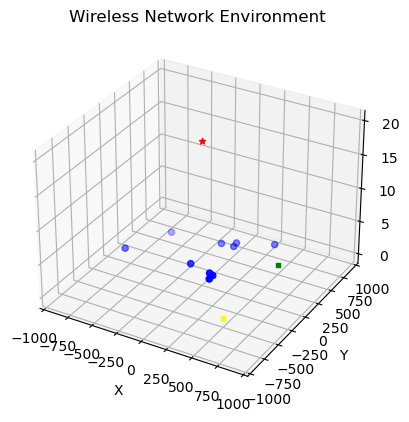

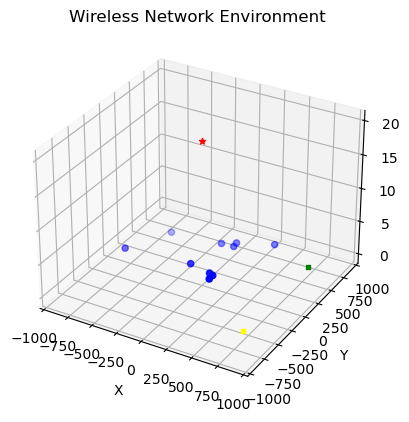

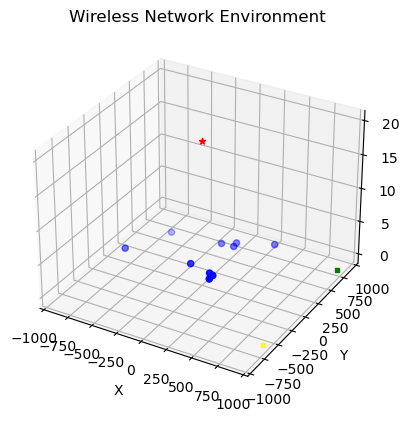

In [97]:
arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

avg_EE = np.zeros((len(arr_gridradius), 1))
RATE_THRESHOLD = 20
B = None
results_dict = {}

for i in range(4):
        xs_1, ys_1, zs_1 = IRS_POSITIONS_1[i]
        xs_2, ys_2, zs_2 = IRS_POSITIONS_2[i]
# ---------------------------------------------------------Calculating distances for IRS-----------------------------------------------------------------------------------        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
                # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
                # print()
                
        irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_2 = irs_coords_2
                # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
                # print()
                
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
                # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
                # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
                # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
                # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
                # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
                # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
                # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

        
        fig = plt.figure()
        ax = plt.axes(projection ="3d")
        ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
        ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
        plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')
        plt.scatter(xs_2, ys_2, zs_2, color='yellow', marker='s', label='IRS_2')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.axis([-1000,1000,-1000,1000])
        ax.set_title('Wireless Network Environment')
        # ax.legend()
        ax.grid(True)
        print('BS position:'"\n" , BASE_STATION_POSITION)
        print('IRS-1 position:'"\n" , IRS_POSITIONS_1[i])
        print('IRS-2 position:'"\n" , IRS_POSITIONS_2[i])

# -----------------------------------------SIMULATING FOR 4 DIFFERENT LOCATIONS and caluculating EE wrt each location-----------------------------------------------------------------------------------        
        EE = np.zeros((NUM_SIMULATIONS,1))
        for s in range(NUM_SIMULATIONS):
                h_dk = np.zeros((K,1))
                
                # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
                fading = []
                for user in range(K):
                        fading.append(generate_nakagami_samples(m,omega,Ns)) 
                h_rk1 = fading
                h_rk1 = np.reshape(h_rk1,(Ns,K))
                h_rk1_transpose = np.transpose(h_rk1)
                h_rk1_h = np.conj(h_rk1_transpose)


                # Generate the Nakagami Channel from each user to the IRS-2 (h_rk2)
                fading = []
                for user in range(K):
                        fading.append(generate_nakagami_samples(m,omega,Ns)) 
                h_rk2 = fading
                h_rk2 = np.reshape(h_rk2,(Ns,K))
                h_rk2_transpose = np.transpose(h_rk2)
                h_rk2_h = np.conj(h_rk2_transpose)

                # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
                G1 = generate_nakagami_samples(m,omega,Ns) 
                G1 = np.reshape(G1,(Ns,1))


                # Generate the Nakagami Channel from base_station to the IRS-2 (G2)
                G2 = generate_nakagami_samples(m,omega,Ns)
                G2 = np.reshape(G2,(Ns,1))

                theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G1, K= K, Ns= Ns, quantized_theta_set= None)
                theta_2 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk2, g= G2, K= K, Ns= Ns, quantized_theta_set= None)

                results_array_1 = prod_matrix(theta_1, h_rk1_h, G1, K, Ns)
                results_array_2 = prod_matrix(theta_2, h_rk2_h, G2, K, Ns)

# ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
                arr_link_budget = np.zeros((K,1))
                for m in range (K):
                        arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ZETA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_2**BETA))))))
                        arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                        arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                        arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                        outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
                arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
                # print('For N:', Ns, 'Sum rate:', arr_sumrate_disc) 

                power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
                power_21 = compute_power_consumption_at_ris(B, Ns)
                power_22 = compute_power_consumption_at_ris(B, Ns)
                power_3 = (10**(Pu/10))/1000
                power_3 = power_3 * K
                P = power_1 + power_21 + power_22 + power_3
                EE[s] = (compute_energy_efficiency(arr_sumrate_disc[s], P)) / 1e6
        avg_EE[i] = compute_average_energy_efficiency(EE)
        results_dict[i] = avg_EE



                




(1, 4)
[[ 250  500  750 1000]]
[[91.1040499  75.42438339 62.44718976 52.14199832]]


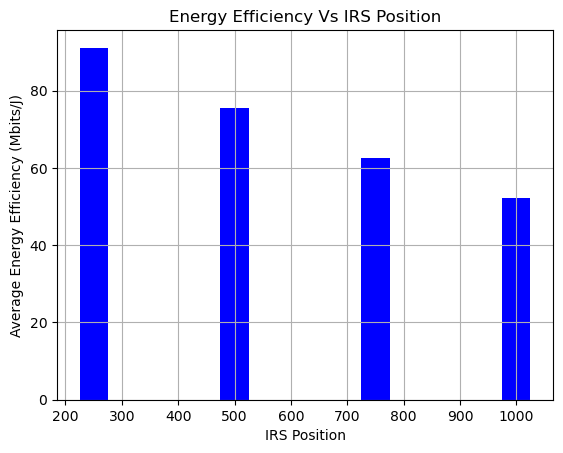

In [98]:
# Plot the graph for each value of N

arr_gridradius = np.reshape((arr_gridradius), (1,4))
avg_EE = np.reshape((avg_EE), (1,4))

print(avg_EE.shape)
print(arr_gridradius)
print(avg_EE)
for i in range(4):
    bar_width = 50
    plt.bar(arr_gridradius[:,i], avg_EE[:,i], color='blue', alpha=1, width=bar_width)


plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('IRS Position')
plt.title('Energy Efficiency Vs IRS Position')
plt.grid(True)
plt.show()



Fixing one IRS and moving the other

BS position:
 (0, 0, 20)
IRS-1 position:
 [250 400  10]
IRS-2 position:
 [ 250 -400   10]
BS position:
 (0, 0, 20)
IRS-1 position:
 [250 400  10]
IRS-2 position:
 [ 500 -500   10]
BS position:
 (0, 0, 20)
IRS-1 position:
 [250 400  10]
IRS-2 position:
 [ 750 -600   10]
BS position:
 (0, 0, 20)
IRS-1 position:
 [250 400  10]
IRS-2 position:
 [1000 -700   10]


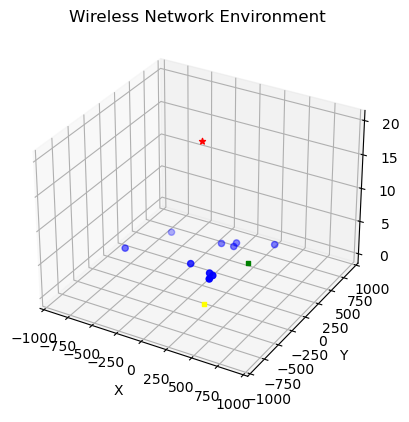

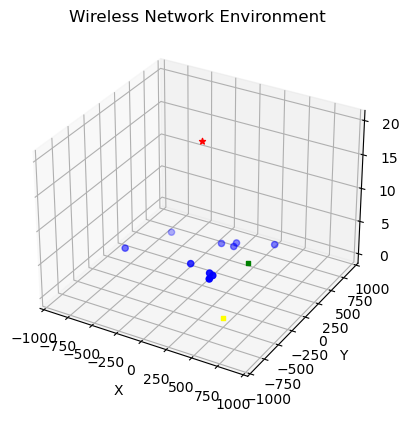

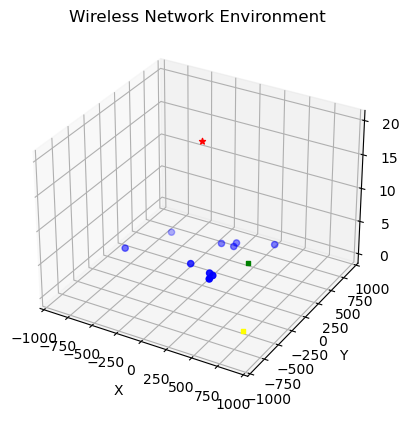

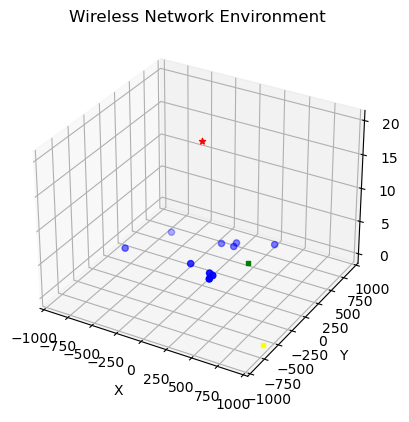

In [99]:
arr_gridradius = np.arange(250,1250,250) # dividing by 0.5 to cater to angle while remianing in concentric boundaries
arr_gridradius = np.array(arr_gridradius)

IRS_X = np.arange(250,1250,250)
IRS_Y = np.arange(400,800,100)
IRS_Z = np.array([10,10,10,10])
IRS_POSITIONS_1 = np.array([250,400,10])
IRS_POSITIONS_2 = np.column_stack((IRS_X, -IRS_Y, IRS_Z))

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

avg_EE = np.zeros((len(arr_gridradius), 1))
RATE_THRESHOLD = 20
B = None
results_dict = {}

for i in range(4):
        xs_1, ys_1, zs_1 = IRS_POSITIONS_1
        xs_2, ys_2, zs_2 = IRS_POSITIONS_2[i]
# ---------------------------------------------------------Calculating distances for IRS-----------------------------------------------------------------------------------        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
                # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
                # print()
                
        irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_2 = irs_coords_2
                # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
                # print()
                
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
                # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
                # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
                # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
                # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
                # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
                # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
                # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

        
        fig = plt.figure()
        ax = plt.axes(projection ="3d")
        ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
        ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
        plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')
        plt.scatter(xs_2, ys_2, zs_2, color='yellow', marker='s', label='IRS_2')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.axis([-1000,1000,-1000,1000])
        ax.set_title('Wireless Network Environment')
        # ax.legend()
        ax.grid(True)
        print('BS position:'"\n" , BASE_STATION_POSITION)
        print('IRS-1 position:'"\n" , IRS_POSITIONS_1)
        print('IRS-2 position:'"\n" , IRS_POSITIONS_2[i])

# -----------------------------------------SIMULATING FOR 4 DIFFERENT LOCATIONS and caluculating EE wrt each location-----------------------------------------------------------------------------------        
        EE = np.zeros((NUM_SIMULATIONS,1))
        for s in range(NUM_SIMULATIONS):
                h_dk = np.zeros((K,1))
                
                # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
                fading = []
                for user in range(K):
                        fading.append(generate_nakagami_samples(m,omega,Ns)) 
                h_rk1 = fading
                h_rk1 = np.reshape(h_rk1,(Ns,K))
                h_rk1_transpose = np.transpose(h_rk1)
                h_rk1_h = np.conj(h_rk1_transpose)


                # Generate the Nakagami Channel from each user to the IRS-2 (h_rk2)
                fading = []
                for user in range(K):
                        fading.append(generate_nakagami_samples(m,omega,Ns)) 
                h_rk2 = fading
                h_rk2 = np.reshape(h_rk2,(Ns,K))
                h_rk2_transpose = np.transpose(h_rk2)
                h_rk2_h = np.conj(h_rk2_transpose)

                # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
                G1 = generate_nakagami_samples(m,omega,Ns) 
                G1 = np.reshape(G1,(Ns,1))


                # Generate the Nakagami Channel from base_station to the IRS-2 (G2)
                G2 = generate_nakagami_samples(m,omega,Ns)
                G2 = np.reshape(G2,(Ns,1))

                theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G1, K= K, Ns= Ns, quantized_theta_set= None)
                theta_2 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk2, g= G2, K= K, Ns= Ns, quantized_theta_set= None)

                results_array_1 = prod_matrix(theta_1, h_rk1_h, G1, K, Ns)
                results_array_2 = prod_matrix(theta_2, h_rk2_h, G2, K, Ns)

# ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
                arr_link_budget = np.zeros((K,1))
                for m in range (K):
                        arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ZETA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_2**BETA))))))
                        arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                        arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                        arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                        outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
                arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
                # print('For N:', Ns, 'Sum rate:', arr_sumrate_disc) 

                power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
                power_21 = compute_power_consumption_at_ris(B, Ns)
                power_22 = compute_power_consumption_at_ris(B, Ns)
                power_3 = (10**(Pu/10))/1000
                power_3 = power_3 * K
                P = power_1 + power_21 + power_22 + power_3
                EE[s] = (compute_energy_efficiency(arr_sumrate_disc[s], P)) / 1e6
        avg_EE[i] = compute_average_energy_efficiency(EE)
        results_dict[i] = avg_EE



                





(1, 4)
[[ 250  500  750 1000]]
[[90.92768601 90.56977268 90.74851555 90.90318195]]


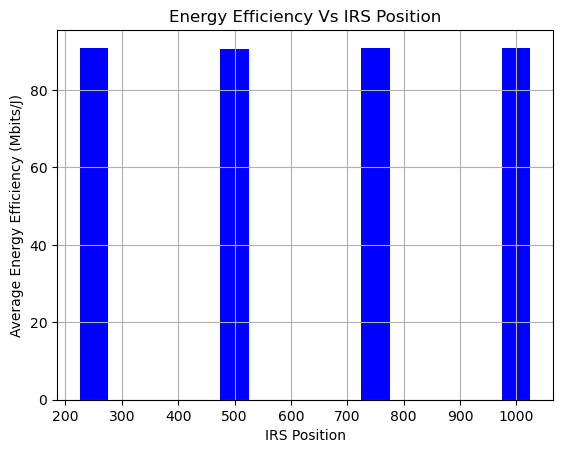

In [100]:
# Plot the graph for each value of N

arr_gridradius = np.reshape((arr_gridradius), (1,4))
avg_EE = np.reshape((avg_EE), (1,4))

print(avg_EE.shape)
print(arr_gridradius)
print(avg_EE)
for i in range(4):
    bar_width = 50
    plt.bar(arr_gridradius[:,i], avg_EE[:,i], color='blue', alpha=1, width=bar_width)


plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('IRS Position')
plt.title('Energy Efficiency Vs IRS Position')
plt.grid(True)
plt.show()



BS position:
 (0, 0, 20)
IRS-1 position:
 [ 250 -400   10]
IRS-2 position:
 [250 400  10]
BS position:
 (0, 0, 20)
IRS-1 position:
 [ 500 -500   10]
IRS-2 position:
 [250 400  10]
BS position:
 (0, 0, 20)
IRS-1 position:
 [ 750 -600   10]
IRS-2 position:
 [250 400  10]
BS position:
 (0, 0, 20)
IRS-1 position:
 [1000 -700   10]
IRS-2 position:
 [250 400  10]


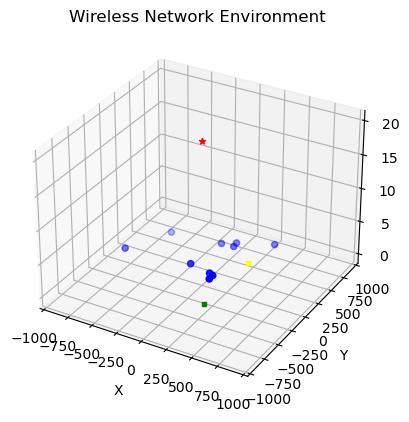

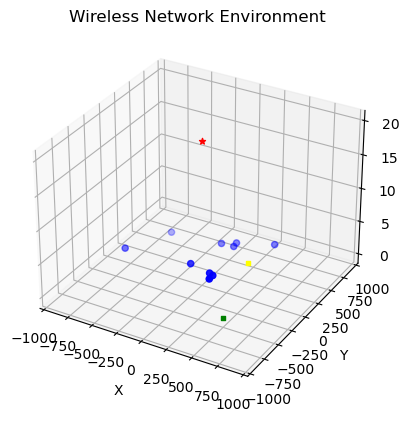

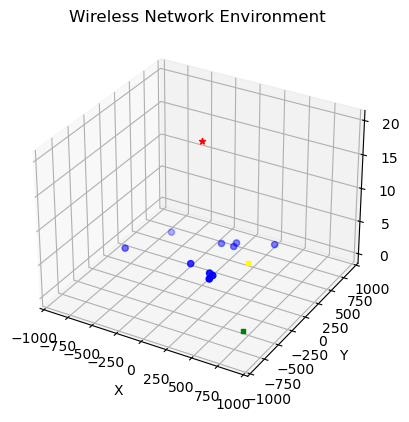

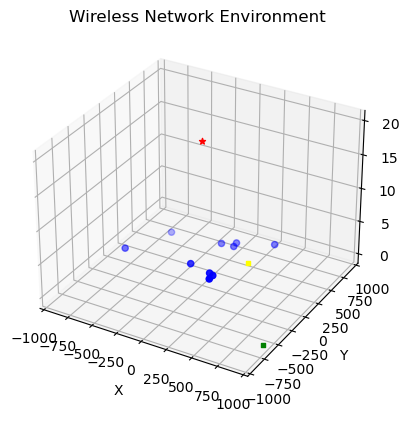

In [101]:
arr_gridradius = np.arange(250,1250,250) # dividing by 0.5 to cater to angle while remianing in concentric boundaries
arr_gridradius = np.array(arr_gridradius)
IRS_X = np.arange(250,1250,250)
IRS_Y = np.arange(400,800,100)
IRS_Z = np.array([10,10,10,10])
IRS_POSITIONS_1 = np.column_stack((IRS_X, -IRS_Y, IRS_Z))
IRS_POSITIONS_2 = np.array([250,400,10])

arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))

avg_EE = np.zeros((len(arr_gridradius), 1))
RATE_THRESHOLD = 20
B = None
results_dict = {}

for i in range(4):
        xs_1, ys_1, zs_1 = IRS_POSITIONS_1[i]
        xs_2, ys_2, zs_2 = IRS_POSITIONS_2
# ---------------------------------------------------------Calculating distances for IRS-----------------------------------------------------------------------------------        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
                # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
                # print()
                
        irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_2 = irs_coords_2
                # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
                # print()
                
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
                # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
                # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
                # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
                # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
                # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
                # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
                # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

        
        fig = plt.figure()
        ax = plt.axes(projection ="3d")
        ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
        ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
        plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')
        plt.scatter(xs_2, ys_2, zs_2, color='yellow', marker='s', label='IRS_2')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.axis([-1000,1000,-1000,1000])
        ax.set_title('Wireless Network Environment')
        # ax.legend()
        ax.grid(True)
        print('BS position:'"\n" , BASE_STATION_POSITION)
        print('IRS-1 position:'"\n" , IRS_POSITIONS_1[i])
        print('IRS-2 position:'"\n" , IRS_POSITIONS_2)

# -----------------------------------------SIMULATING FOR 4 DIFFERENT LOCATIONS and caluculating EE wrt each location-----------------------------------------------------------------------------------        
        EE = np.zeros((NUM_SIMULATIONS,1))
        for s in range(NUM_SIMULATIONS):
                h_dk = np.zeros((K,1))
                
                # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
                fading = []
                for user in range(K):
                        fading.append(generate_nakagami_samples(m,omega,Ns)) 
                h_rk1 = fading
                h_rk1 = np.reshape(h_rk1,(Ns,K))
                h_rk1_transpose = np.transpose(h_rk1)
                h_rk1_h = np.conj(h_rk1_transpose)


                # Generate the Nakagami Channel from each user to the IRS-2 (h_rk2)
                fading = []
                for user in range(K):
                        fading.append(generate_nakagami_samples(m,omega,Ns)) 
                h_rk2 = fading
                h_rk2 = np.reshape(h_rk2,(Ns,K))
                h_rk2_transpose = np.transpose(h_rk2)
                h_rk2_h = np.conj(h_rk2_transpose)

                # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
                G1 = generate_nakagami_samples(m,omega,Ns) 
                G1 = np.reshape(G1,(Ns,1))


                # Generate the Nakagami Channel from base_station to the IRS-2 (G2)
                G2 = generate_nakagami_samples(m,omega,Ns)
                G2 = np.reshape(G2,(Ns,1))

                theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G1, K= K, Ns= Ns, quantized_theta_set= None)
                theta_2 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk2, g= G2, K= K, Ns= Ns, quantized_theta_set= None)

                results_array_1 = prod_matrix(theta_1, h_rk1_h, G1, K, Ns)
                results_array_2 = prod_matrix(theta_2, h_rk2_h, G2, K, Ns)

# ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
                arr_link_budget = np.zeros((K,1))
                for m in range (K):
                        arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ZETA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**ALPHA)*(dTS_1**ALPHA)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA)*(dTS_2**BETA))))))
                        arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                        arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                        arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                        outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
                arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
                # print('For N:', Ns, 'Sum rate:', arr_sumrate_disc) 

                power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
                power_21 = compute_power_consumption_at_ris(B, Ns)
                power_22 = compute_power_consumption_at_ris(B, Ns)
                power_3 = (10**(Pu/10))/1000
                power_3 = power_3 * K
                P = power_1 + power_21 + power_22 + power_3
                EE[s] = (compute_energy_efficiency(arr_sumrate_disc[s], P)) / 1e6
        avg_EE[i] = compute_average_energy_efficiency(EE)
        results_dict[i] = avg_EE



                





(1, 4)
[[ 250  500  750 1000]]
[[79.3156051  66.14019543 55.13706298 46.53977403]]


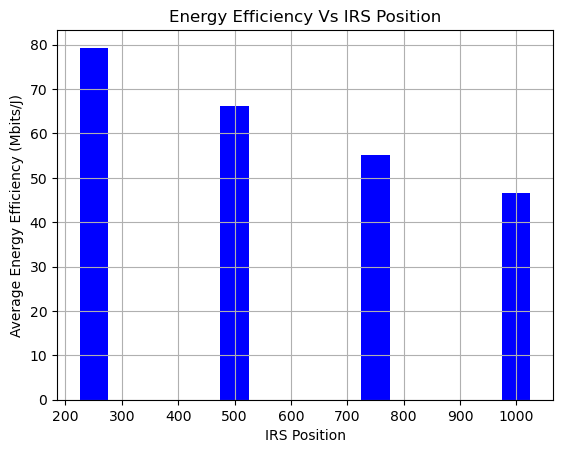

In [102]:
# Plot the graph for each value of N

arr_gridradius = np.reshape((arr_gridradius), (1,4))
avg_EE = np.reshape((avg_EE), (1,4))

print(avg_EE.shape)
print(arr_gridradius)
print(avg_EE)
for i in range(4):
    bar_width = 50
    plt.bar(arr_gridradius[:,i], avg_EE[:,i], color='blue', alpha=1, width=bar_width)


plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('IRS Position')
plt.title('Energy Efficiency Vs IRS Position')
plt.grid(True)
plt.show()

